# All Ireland M.bovis strain diversity and clade identification

In [126]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting, rdiff
import toytree, toyplot
import toyplot.pdf
path = '/storage/btbgenie/all_ireland_results'

## get meta data

In [127]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
print (len(meta))

636


In [ ]:
dups=meta[meta.duplicated('aliquot')].dropna()
#print (dups)
for i,r in dups.iterrows():
    print (meta[meta.aliquot== r.aliquot])
#meta[(meta.batch.isin([2,3,4])) & (~meta.aliquot.isin(dups.aliquot)) & (meta.county=='Monaghan')]

## run NI

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/NI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/NI'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## misc 2021 samples (Kevin)

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/misc_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/Misc'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
reload(app)
mask='/home/farrell/gitprojects/snipgenie/snipgenie/data/Mbovis_AF212297_mask.bed'
vcf_file='/storage/btbgenie/misc_results/snps.vcf.gz'
app.mask_filter(vcf_file, mask)

In [244]:
present=pd.read_csv('/storage/btbgenie/misc_results/summary.csv')
present['sample']=present['sample'].astype(str)
#print (present[:10])
l=list(W.fastq_table['sample'].unique())

s=meta[meta.batch>=3].sort_values(by='sample')
#s['label'] = s['sample'].apply(lambda x : x.split('-')[1][-4:]).astype(str)
#s=s.sort_values('label')

p = present[~present['sample'].isin(s['sample'])]
#p = (s[s['label'].isin(l)])
print (p)
print (len(s),len(p), len(present))

         sample                           name                                           bam_file  read_length
25  TB19-004280  TB19-004280_S68_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-004...          149
48  TB19-005887  TB19-005887_S29_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-005...          150
65 2 61


In [284]:
reload(trees)
spo=pd.read_csv('/storage/btbgenie/all_ireland_results/misc_spoligotypes.csv')
treefile = '/storage/btbgenie/misc_results/tree.newick'
tre = toytree.tree(treefile)
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['sample'],meta.county))
colormap = trees.colors_from_labels(meta,'name','county')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]

canvas,t,r=tre.draw(layout='r',width=1000,height=1000,tip_labels_colors=tip_colors,
                    scalebar=True,);
toyplot.pdf.render(canvas,'/storage/btbgenie/all_ireland_results/misc_samples_tree.pdf')

## run CVRL samples

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/cvrl_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/CVRL'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## UK samples?

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/UK_results', 'labelsep':'_',
        'input':['/storage/btbgenie/??'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
reload(trees)
spo=pd.read_csv('/storage/btbgenie/all_ireland_results/cvrl_spoligotypes.csv')
treefile = '/storage/btbgenie/cvrl_results/tree.newick'
tre = toytree.tree(treefile)
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['sample'],meta.county))
colormap = trees.colors_from_labels(meta,'name','county')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]

canvas,t,r=tre.draw(layout='r',width=1000,height=1400,tip_labels_colors=tip_colors,
                    scalebar=True,);

## integrate previously aligned bam files together and call variants

This allows us to join previously mapped results together in one call without re-aligning

In [152]:
outdir='/storage/btbgenie/all_ireland_results'

folders = {'wicklow':'/storage/btbgenie/wicklow_results',
          'cvrl':'/storage/btbgenie/cvrl_results',
          'misc':'/storage/btbgenie/misc_results',
          'monaghan':'/storage/btbgenie/monaghan/monaghan_results',
          'NI':'/storage/btbgenie/NI_results/'         
          }

x=[]
for f in folders:
    print (f)
    file = os.path.join(folders[f],'samples.csv')   
    df=pd.read_csv(file)
    x.append(df)
samples = pd.concat(x)
print (len(samples))
samples.to_csv('/storage/btbgenie/all_ireland_results/samples.csv',index=False)
app.write_samples(samples[['sample']], outdir)
bam_files = list(samples.bam_file)

wicklow
cvrl
misc
monaghan
NI
570


## run previously aligned files

In [4]:
reload(app)
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/all_ireland_results', threads=16,                
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True, overwrite=False)

raxmlHPC-PTHREADS -f a -N 100 -T 8 -m GTRCAT -V -p 14234711 -x 86378030 -n variants -w /storage/btbgenie/all_ireland_results -s /storage/btbgenie/all_ireland_results/core.fa


## spoligotypes of all samples

In [153]:
reload(tools)
spo = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')
done=list(spo['sample'])
res=[]
for i,r in samples.iterrows():
    f=r.filename1
    samp=r['sample']
    if samp in done:
        continue
    b = tools.get_spoligotype(f)
    sb = tools.get_sb_number(b)
    print (f,samp,sb, b)
    res.append([f,samp,sb,b])
 
res = pd.DataFrame(res,columns=['filename','sample','SB','code'])
#append new spotypes to current file
res=pd.concat([spo,res])

In [154]:
len(res),len(meta)
#meta[~meta['sample'].isin(res['sample'])]
#res.to_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv',index=False)

<div class="alert alert-block alert-info"><b>Post analysis starts here</b> </div>

## clusters

In [155]:
clusts = trees.get_clusters('/storage/btbgenie/all_ireland_results/tree.newick')

TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 3 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 5 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 7 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 10 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 12 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 20 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 50 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 100 -m max_clade


[25, 71, 92, 17, 37, 9, 22, 80, 27, 90, 85, 30, 11, 70, 89, 52, 79, 74, 68]


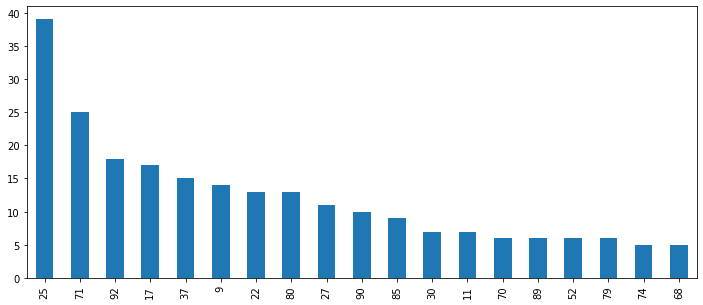

In [129]:
cc = clusts.snp12.value_counts()[1:20]
cc.plot(kind='bar',figsize=(12,5))
print (list(cc.index))

In [130]:
common = meta.county.value_counts()[:7]
def cty_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
meta['county1'] = meta.county.apply(cty_comm)
meta['county2'] = meta.county.apply(lambda x : x if x in ['Monaghan','Clare'] else 'Other')
common

Monaghan    192
Clare       157
NI           86
Wicklow      50
Cork         26
Meath        16
Cavan        13
Name: county, dtype: int64

In [134]:
spo = pd.read_csv('/storage/btbgenie/all_ireland_results/spoligotypes.csv')

In [136]:
final = meta.merge(spo[['sample','SB']],on='sample',how='left')
final = final.merge(clusts,left_on='sample',right_on='SequenceName')
len(final)

567

In [137]:
common = final.SB.value_counts()[:6]
def sb_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
final['SB1'] = final.SB.apply(sb_comm)   

## assign clade names - replace with lineage calling?

In [ ]:
import string
labels=list(string.ascii_uppercase)
clmap={}
found=[]
i=0
for c,g in final.groupby('ClusterNumber'):    
    if len(g)==0: continue    
    cts = g.county.value_counts()
    top = cts[0]
    if top>10:         
        clmap[c]=labels[i]
        i+=1
    else:
        clmap[c]='Other'

## RD analysis

In [ ]:
reload(rdiff)
rdiff.create_rd_index()
samples = pd.read_csv('/storage/btbgenie/all_ireland_results/samples.csv')
res = rdiff.run_samples(samples,'/storage/btbgenie/all_ireland_results/rd_aligned',threads=12)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
X.to_csv('/storage/btbgenie/mbovis_ireland/rd.csv')

In [ ]:
reload(rdiff)
rdiff.show_rd_coverage(samples[:4], 'LT708304.1',4310000,4330000,app.mbovis_genome,app.mbovis_gb,margin=1300)

In [69]:
wick=list(meta[meta.county=='Wicklow']['sample'])

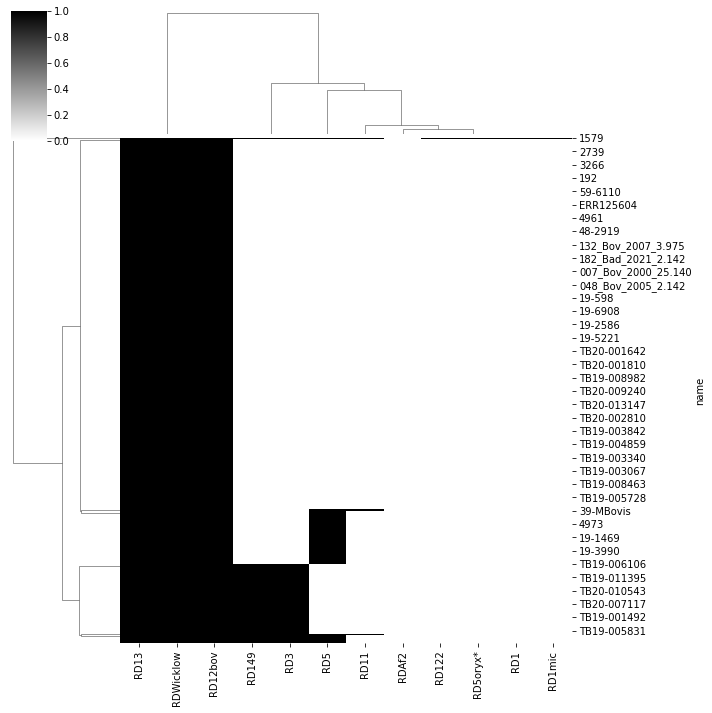

In [138]:
R=pd.read_csv('/storage/btbgenie/mbovis_ireland/rd.csv',index_col=0)
R=R.iloc[:,:-1]
#cols=X.columns[(X.sum()<len(X)-1) & (X.sum()>0)]
cols = ['RD1','RD1mic','RDWicklow','RD11','RD12bov','RD13','RD149','RD3','RD5','RD5oryx*','RD122','RDAf2']
R = R[cols]
#fig,ax=plt.subplots(1,1,figsize=(10,10))
sns.clustermap(R,cmap='gray_r',figsize=(10,10))

In [139]:
final = final.merge(R,left_on='sample',right_index=True)
final.to_csv('/storage/btbgenie/all_ireland_results/metadata.csv',index=False)

## draw all ireland tree

In [ ]:
treefile = '/storage/btbgenie/all_ireland_results/tree.newick'
tre = toytree.tree(treefile)
canvas,t,r=tre.draw(height=1000,width=1000)

In [ ]:
reload(trees)
#tre = tre.root('TB20-002800')
#tre = tre.drop_tips('8567')
tipnames = tre.get_tip_labels()
mapping = dict(zip(final['sample'],final.clade))
#mapping['ref'] = 'AF2122/97'
tiplabels = [mapping[i] if i in mapping else 'NA' for i in tipnames]

colormap = trees.colors_from_labels(final,'name','clade')
print (colormap)
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]
tip_labels_style={      
        "font-size": "6px",
        "-toyplot-anchor-shift": "13px",
    }
node_sizes=[0 if i else 5 for i in tre.get_node_values(None, 1, 0)]
node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

canvas,t,r=tre.draw(layout='r',width=1200,height=1300,node_markers="o",node_hover=True, node_sizes=node_sizes,
                    tip_labels=False,tip_labels_style=tip_labels_style,node_colors=node_colors,
                    tip_labels_colors=tip_colors,scalebar=True,edge_widths=1);
#toyplot.pdf.render(canvas,'/storage/btbgenie/all_ireland_results/ireland_tree.pdf')

## SNP analysis

* snps unique to each clade/county
* protein groups containing common snps

In [142]:
csq = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq.tsv')
snp_mat = app.get_aa_snp_matrix(csq)
#csq_ind = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq_indels.tsv')
#ind_mat = app.get_aa_snp_matrix(csq_ind)

In [143]:
#mat.index = mat.index.get_level_values(1)+'_'+mat.index.get_level_values(2)
stat = snp_mat.sum(1).reset_index()
#stat.gene.value_counts()[:30]

In [144]:
cols=['sample','county','SB','snp12']
C=snp_mat.T
C=C.merge(final[cols],left_index=True,right_on='sample').set_index(cols).T
#print (C)
C=C[C.sum(1)>3].T
C.iloc[:4,:2]
C.to_csv('csq_snps_ireland.csv')

<ipython-input-144-d8c25fc0fc61>:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (4 levels on the left, 1 on the right)
  C=C.merge(final[cols],left_index=True,right_on='sample').set_index(cols).T


In [145]:
counties = list(C.index.get_level_values(1))
sb = list(C.index.get_level_values(2))


In [146]:
c=final.county1.unique()
colors=plotting.random_colors(len(c),3)
colormap1 = dict(zip(c, colors))
colors1 = [colormap1[i] if i in colormap1 else 'Black' for i in counties]
#make legend
import matplotlib.patches as mpatches
pts=[]
for c in colormap1:
    pts.append(mpatches.Patch(color=colormap1[c],label=c))
#g=sns.clustermap(C,xticklabels=False,yticklabels=False,figsize=(17,12),cmap='gray_r',cbar_pos=None,row_colors=colors1)
#g.fig.legend(handles=pts,bbox_to_anchor=(1.05, 1), )
#g.savefig('/storage/btbgenie/all_ireland_results/snp_clusters.jpg')

## PCA

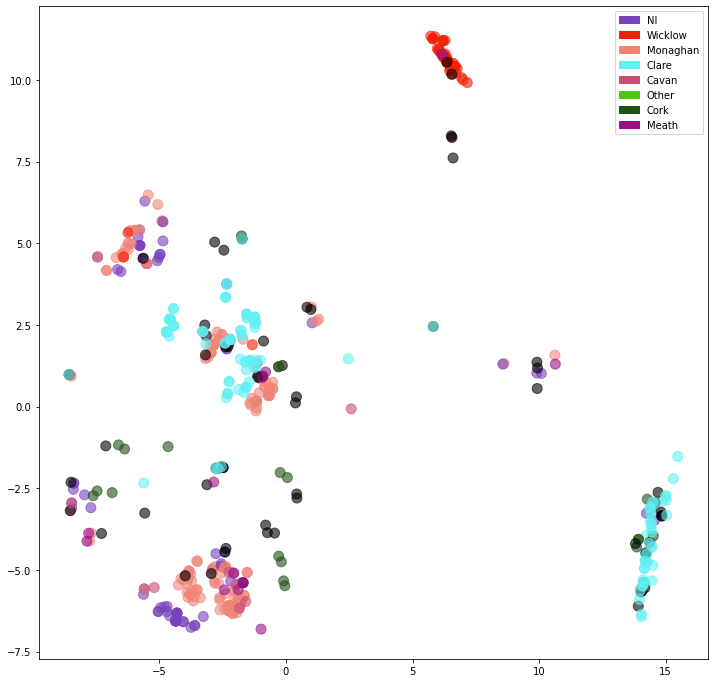

In [147]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(C).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)
df=pd.DataFrame(X)
df['sb']=sb
df.to_csv('/storage/btbgenie/all_ireland_results/pca_snp.csv')

fig,ax = plt.subplots(figsize=(12, 12))
sc=ax.scatter(X[:, 0], X[:, 1], c=colors1, s=100, alpha=.6)    
ax.legend(handles=pts,loc='best')
fig.savefig('/storage/btbgenie/all_ireland_results/pca_snp_clusters.jpg',dpi=150)